In [1]:
import torch
import torch.nn as nn
import pandas as pd 

from matplotlib import pyplot as plt


In [2]:
df = pd.read_csv('particle_data.csv')


In [3]:
def train_test_split(df:pd.DataFrame ):
    crosspoint = len(df)*3//4
    return df[:crosspoint], df[crosspoint:]
df_train, df_test = train_test_split(df)

X_train = df_train 
Y_train = df_train["pid"]
X_train = X_train.drop(columns="pid")

X_test = df_test 
Y_test = df_test["pid"]
X_test = X_test.drop(columns="pid")

X_test

,mass2,p,pT,rapidity,t,v_tof
1363425,0.180881,2.372725,0.454459,1.957612,25.819763,29.496902
1363426,0.012839,0.782998,0.228159,1.753384,27.800797,29.647102
1363427,0.011845,0.940181,0.271188,1.803022,25.498678,29.767570
1363428,0.903536,2.197572,0.629638,1.380773,27.939068,27.363283
1363429,-0.053686,3.453497,0.566588,2.464815,25.582424,30.048048
...,...,...,...,...,...,...
1817896,0.246887,2.584729,0.140964,2.317712,26.839771,29.443060
1817897,0.961281,4.424352,0.344987,2.190138,27.128212,29.262716
1817898,0.035658,1.131818,0.340875,1.796098,26.262580,29.552643
1817899,0.860461,2.839349,0.728590,1.574306,26.653654,28.473682


In [4]:

 
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(6, 16)
        self.act = nn.ReLU()
        self.output = nn.Linear(16, 3)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
model = Multiclass()

import torch.optim as optim
 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:

import tqdm
 
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X_train.values, dtype=torch.float32)
y = torch.tensor(Y_train.values, dtype=torch.long)
X

tensor([[ 1.2064,  8.2179,  0.6370,  2.6754, 25.6588, 29.7129],
        [ 1.1597,  7.7485,  1.1752,  2.3305, 26.5376, 29.6953],
        [ 0.8617,  6.9054,  0.5797,  2.5303, 25.6570, 29.7119],
        ...,
        [ 0.5280, 14.0446,  1.2942,  2.8653, 25.1778, 29.9388],
        [ 0.2030,  2.7064,  0.2538,  2.2834, 26.4925, 29.5628],
        [-0.0793,  4.6214,  0.4947,  2.8866, 26.1856, 30.0352]])

Epoch 0: 100%|██████████| 68171/68171 [01:49<00:00, 619.96batch/s]


tensor(0.0036, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|██████████| 68171/68171 [01:49<00:00, 619.95batch/s]


tensor(0.0007, grad_fn=<NllLossBackward0>)


Epoch 2: 100%|██████████| 68171/68171 [01:50<00:00, 616.08batch/s]


tensor(4.8105e-05, grad_fn=<NllLossBackward0>)


Epoch 3: 100%|██████████| 68171/68171 [01:50<00:00, 615.90batch/s]


tensor(2.3648e-05, grad_fn=<NllLossBackward0>)


Epoch 4: 100%|██████████| 68171/68171 [01:51<00:00, 614.01batch/s]


tensor(1.7992e-05, grad_fn=<NllLossBackward0>)


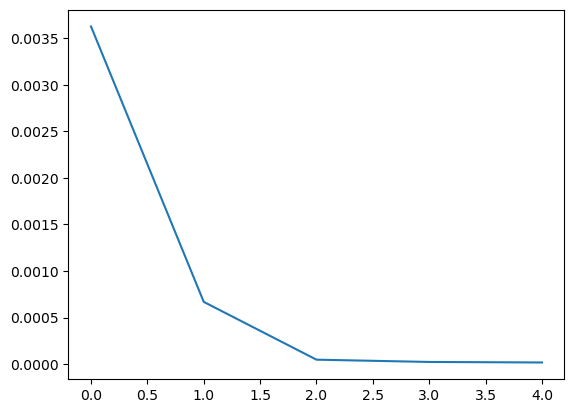

In [9]:

 
# training parameters
n_epochs = 5
batch_size = 20
batches_per_epoch = len(X) // batch_size
loss_history = []
 
for epoch in range(n_epochs):
    loss = 0
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X[start:start+batch_size]
            y_batch = y[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
    print(loss)
    loss_history.append(loss.item())
plt.plot([i for i in range(len(loss_history))],loss_history)

In [11]:
torch.save(model.state_dict(), 'particleclassifier.torch')

In [12]:

X = torch.tensor(X_test.values, dtype=torch.float32)
y_pred = model(X)
y_pred = y_pred.detach().numpy()


In [13]:

y_pred.transpose()[0]

array([ -8.812234, -23.753206, -23.269278, ..., -21.713184,  11.949246,
       -26.376621], dtype=float32)

In [14]:
X_test['pid'] = Y_test
X_test['pid_pred0'], X_test['pid_pred1'], X_test['pid_pred2'] = y_pred.transpose() 

<Axes: >

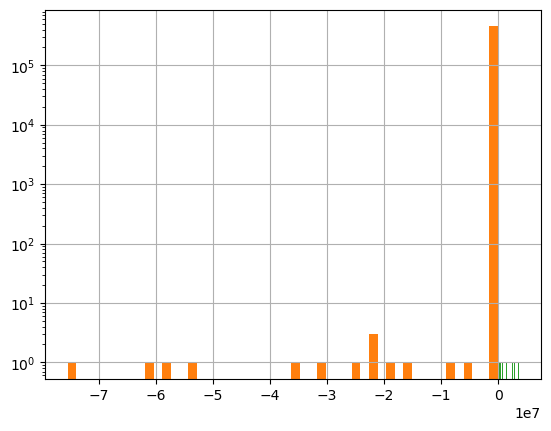

In [15]:
X_test['pid_pred0'].hist(bins=50,log=True)
X_test['pid_pred1'].hist(bins=50, log=True)
X_test['pid_pred2'].hist(bins=50,log=True)

226581
226929
226577
352
protons:
efficiency = 99.99823462691046%
purity = 99.84488540468605%


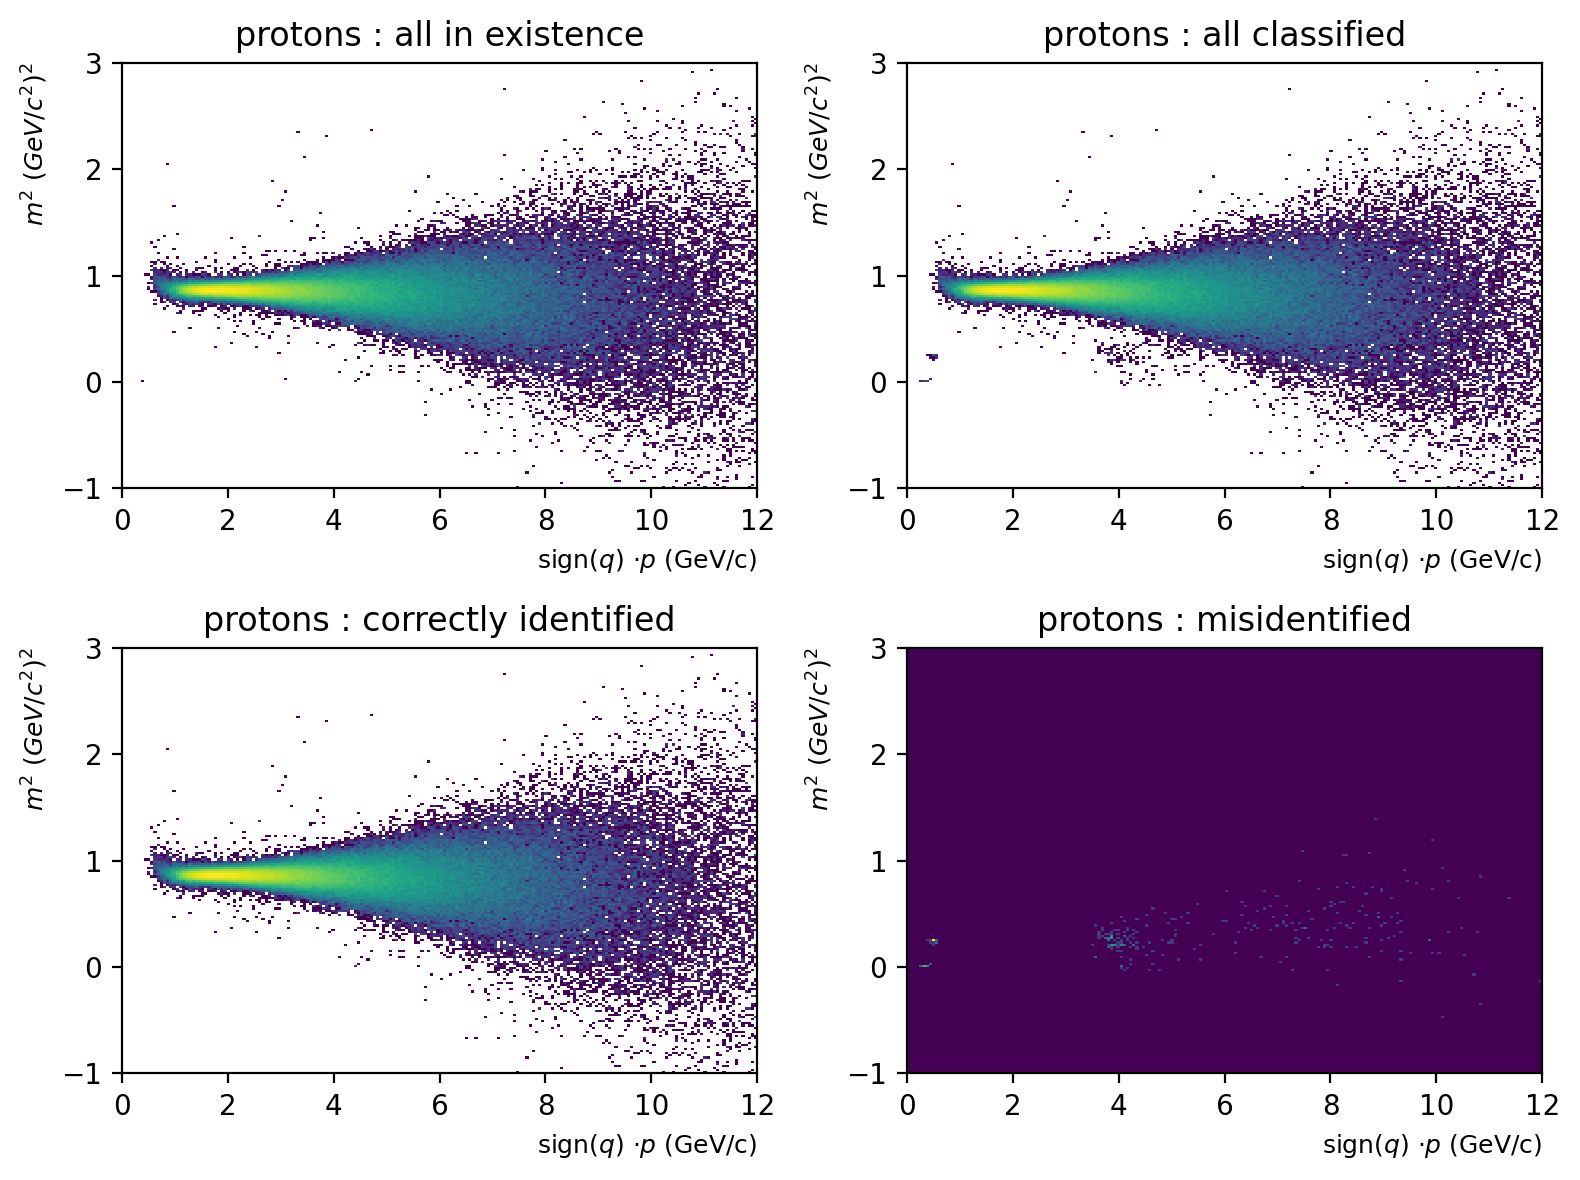

19208
19203
18881
322
kaons:
efficiency = 98.29758433985839%
purity = 98.32317866999948%


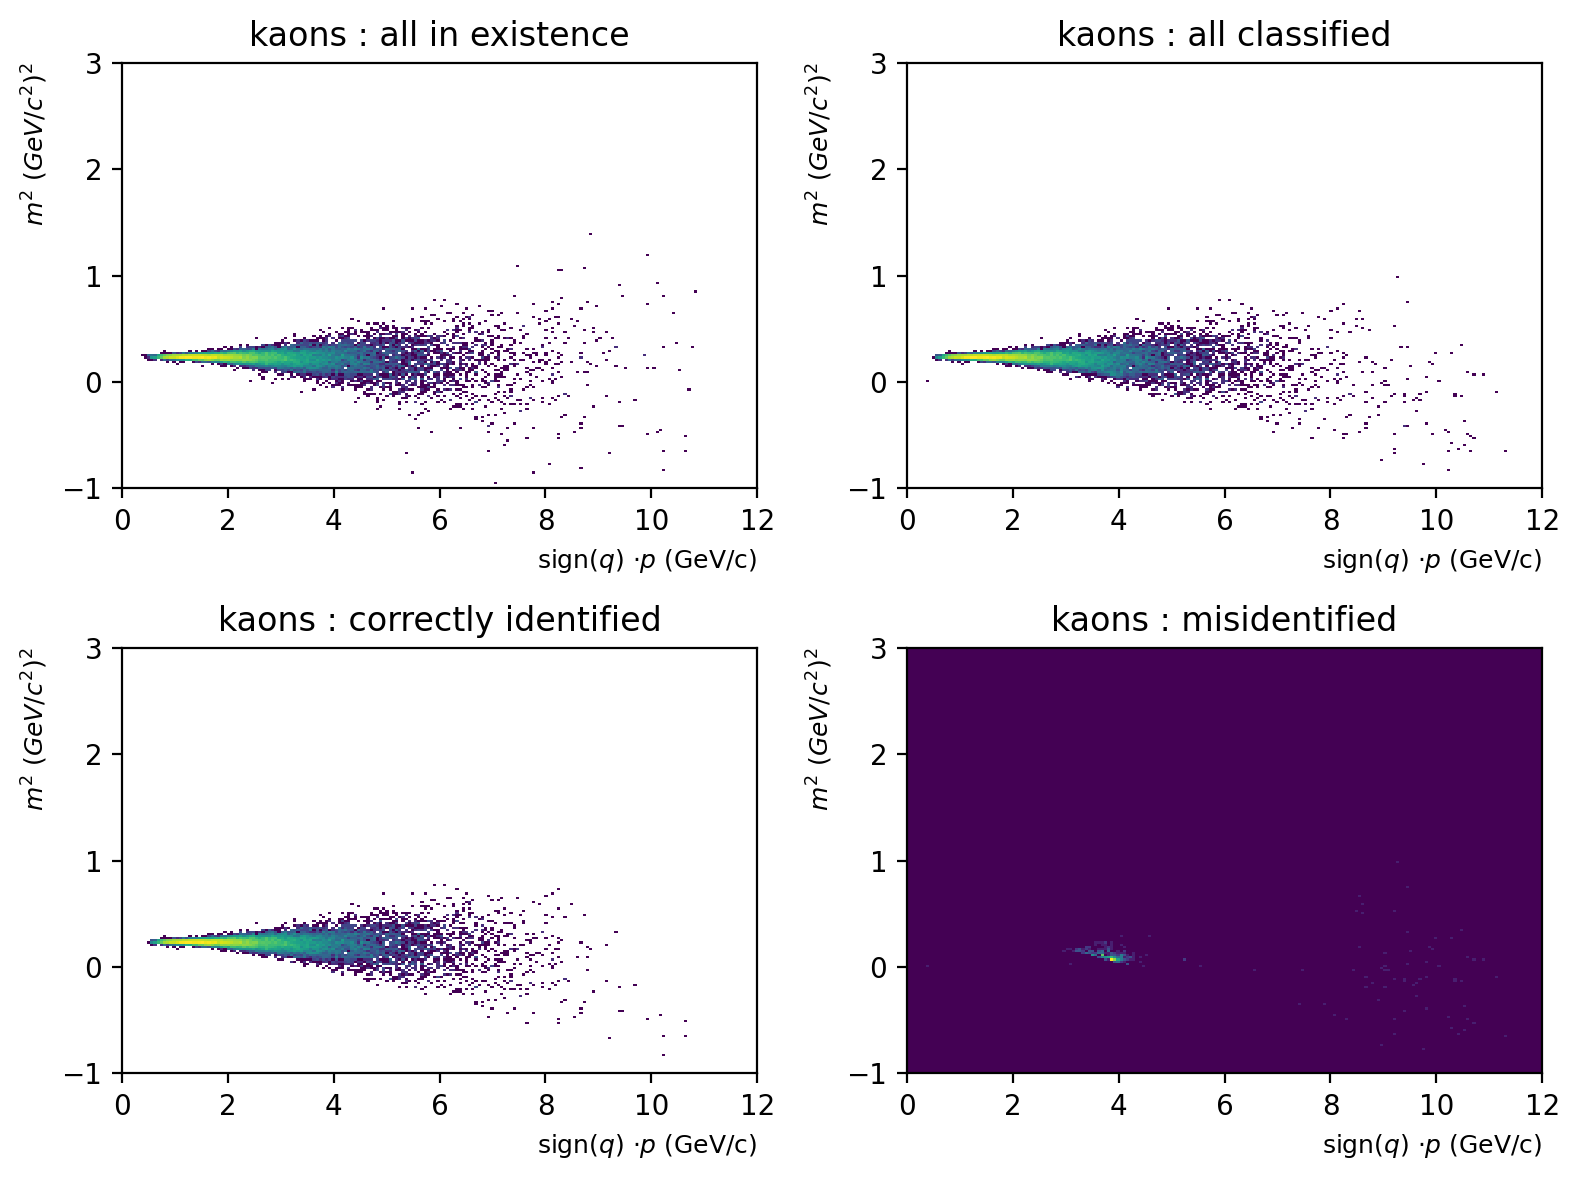

208687
208344
208255
89
pions:
efficiency = 99.7929914177692%
purity = 99.95728218715202%


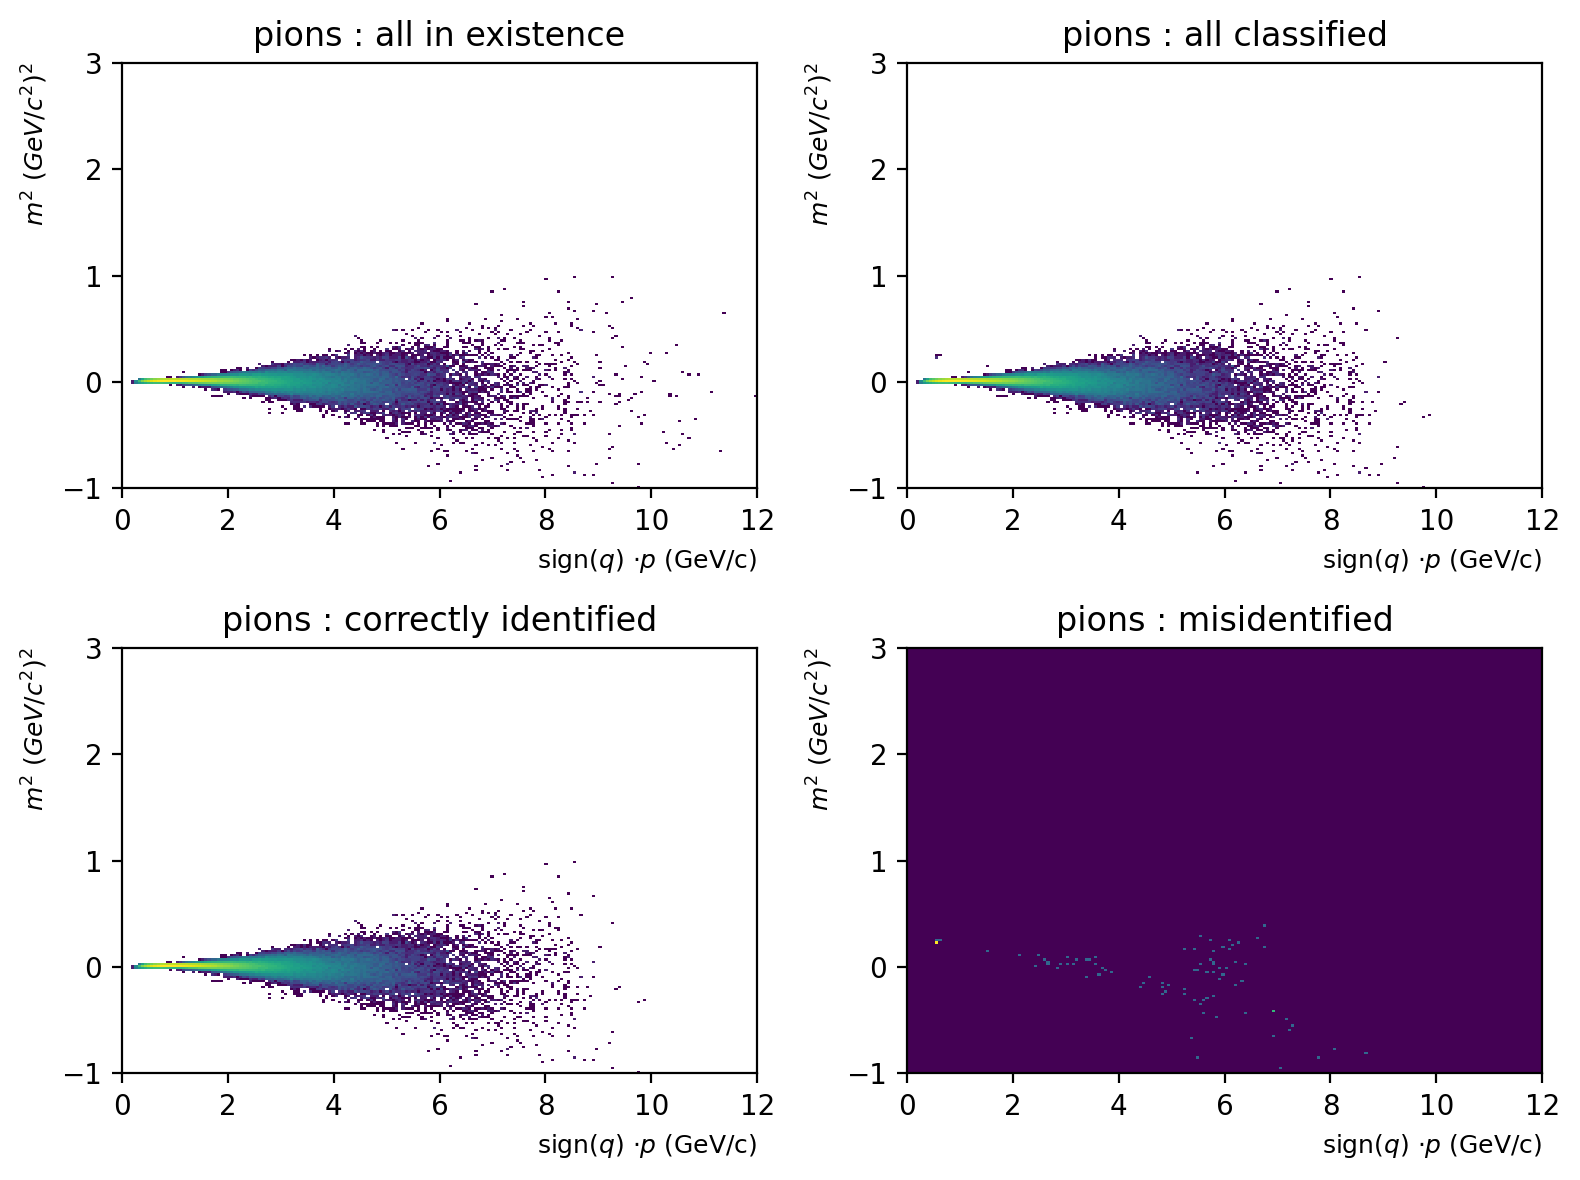

In [16]:

from matplotlib import pyplot as plt
import matplotlib



def selection(df, key):
    return df.loc[(df[key] >= df['pid_pred0']) & (df[key] >= df['pid_pred1']) & (df[key] >= df['pid_pred2']) ] #and df[key]/(df['pid_pred0'] + df['pid_pred1'] + df['pid_pred2']) > minpurity

def draw_tof_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    
    all_protons = df.loc[df['pid'] == pid]
    print(len(all_protons))
    ax[0,0].hist2d(all_protons['p'], all_protons['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])
    
    all_identified = selection(df, key)
    print(len(all_identified))
    ax[0,1].hist2d(all_identified['p'], all_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    well_identified=all_identified.loc[df['pid'] == pid]
    print(len(well_identified))
    ax[1,0].hist2d(well_identified['p'], well_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    misidentified=all_identified.loc[df['pid'] != pid]
    print(len(misidentified))
    ax[1,1].hist2d(misidentified['p'], misidentified['mass2'], bins=200, range=[(0,12), (-1,3)])
    print(f"{particle_name}:")
    print(f"efficiency = {100*len(well_identified)/len(all_protons)}%")
    print(f"purity = {100*len(well_identified)/len(all_identified)}%")

    x_axis_name = r"sign($q$) $\cdot p$ (GeV/c)"
    y_axis_name = r"$m^2$ $(GeV/c^2)^2$"

    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_tof_plot(X_test, 0,'protons')
draw_tof_plot(X_test, 1,'kaons')
draw_tof_plot(X_test, 2,'pions')